<a href="https://colab.research.google.com/github/shintaroudlotulhanafia/TugasAkhirMultipleStocks/blob/main/RunningForMultipleTimes/1_TugasAkhir_Shinta_DRLforMultipleStockTrading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcement Learning for Stock Trading from Scratch: Multiple Stock Trading

* **Pytorch Version** 



# Content

* [1. Task Description](#0)
* [2. Install Python packages](#1)
    * [2.1. Install Packages](#1.1)    
    * [2.2. A List of Python Packages](#1.2)
    * [2.3. Import Packages](#1.3)
    * [2.4. Create Folders](#1.4)
* [3. Download and Preprocess Data](#2)
* [4. Preprocess Data](#3)        
    * [4.1. Technical Indicators](#3.1)
    * [4.2. Perform Feature Engineering](#3.2)
    * [4.3. Seeing Dataset Based on tic](#3.2)
* [5. Build Market Environment in OpenAI Gym-style](#4)  
    * [5.1. Data Split](#4.1)  
    * [5.3. Environment for Training](#4.2)    
* [6. Train DRL Agents](#5)
    * [6.1. Download the Actions of the Agents](#5.1)
* [7. Backtesting Performance](#6)  
    * [7.1. BackTestStats](#6.1)
    * [7.2. BackTestPlot](#6.2)   
  

<a id='0'></a>
# Part 1. Task Discription

We train a DRL agent for stock trading. This task is modeled as a Markov Decision Process (MDP), and the objective function is maximizing (expected) cumulative return.

We specify the state-action-reward as follows:

* **State s**: The state space represents an agent's perception of the market environment. Just like a human trader analyzing various information, here our agent passively observes many features and learns by interacting with the market environment (usually by replaying historical data).

* **Action a**: The action space includes allowed actions that an agent can take at each state. For example, a ∈ {−1, 0, 1}, where −1, 0, 1 represent
selling, holding, and buying. When an action operates multiple shares, a ∈{−k, ..., −1, 0, 1, ..., k}, e.g.. "Buy
10 shares of AAPL" or "Sell 10 shares of AAPL" are 10 or −10, respectively

* **Reward function r(s, a, s′)**: Reward is an incentive for an agent to learn a better policy. For example, it can be the change of the portfolio value when taking a at state s and arriving at new state s',  i.e., r(s, a, s′) = v′ − v, where v′ and v represent the portfolio values at state s′ and s, respectively


**Market environment**: 30 consituent stocks of LQ45 index. Accessed at the starting date of the testing period.


The data for this case study is obtained from Yahoo Finance API. The data contains Open-High-Low-Close price and volume.


<a id='1'></a>
# Part 2. Install Python Packages

<a id='1.1'></a>
## 2.1. Install packages


In [52]:
## install finrl library
!pip install git+https://github.com/shintaroudlotulhanafia/FinRL.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/shintaroudlotulhanafia/FinRL.git to /tmp/pip-req-build-m2_nxjz6
  Running command git clone -q https://github.com/shintaroudlotulhanafia/FinRL.git /tmp/pip-req-build-m2_nxjz6
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-s037arjp/pyfolio_7bb9474f5c604575a6ca5248bef027d3
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-s037arjp/pyfolio_7bb9474f5c604575a6ca5248bef027d3
  Cloning https://github.com/AI4Finance-Foundation/ElegantRL.git to /tmp/pip-install-s037arjp/elegantrl_5fda31614c7645acb8228cb5de01da87
  Running command git clone -q https://github.com/AI4Finance-Foundation/ElegantRL.git /tmp/pip-install-s037arjp/elegantrl_5fda31614c7645acb8228cb5de01da87



<a id='1.2'></a>
## 2.2. A list of Python packages 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

<a id='1.3'></a>
## 2.3. Import Packages

In [53]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools

<a id='1.4'></a>
## 2.4. Create Folders

In [54]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).



-----
class YahooDownloader:
    Retrieving daily stock data from
    Yahoo Finance API

    Attributes
    ----------
        start_date : str
            start date of the data
        end_date : str
            end date of the data
        ticker_list : list
            a list of stock tickers (modified from config.py)

    Methods
    -------
    fetch_data()


In [55]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2020-06-30'
TRADE_START_DATE = '2020-07-01'
TRADE_END_DATE = '2021-12-31'

In [56]:
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = config_tickers.DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [122]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [58]:
df.shape

(95591, 8)

In [59]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic,day
0,2009-01-02,3.067143,3.251429,3.041429,2.767329,746015200,AAPL,4
1,2009-01-02,58.590000,59.080002,57.750000,44.867592,6547900,AMGN,4
2,2009-01-02,18.570000,19.520000,18.400000,15.477422,10955700,AXP,4
3,2009-01-02,42.799999,45.560001,42.779999,33.941097,7010200,BA,4
4,2009-01-02,44.910000,46.980000,44.709999,31.942255,7117200,CAT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 1998, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [60]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    tech_indicator_list = INDICATORS,
                    use_vix=True,
                    use_turbulence=True,
                    user_defined_feature = False)

processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3271, 8)
Successfully added vix
Successfully added turbulence index


In [61]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [62]:
processed_full.sort_values(['date','tic'],ignore_index=True).head(10)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.767329,746015200.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,2.767329,2.767329,39.189999,0.0
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.867592,6547900.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,44.867592,44.867592,39.189999,0.0
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.477422,10955700.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,15.477422,15.477422,39.189999,0.0
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,33.941097,33.941097,39.189999,0.0
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.942255,7117200.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,31.942255,31.942255,39.189999,0.0
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,8.505000,8.505000,39.189999,0.0
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.155674,40980600.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,12.155674,12.155674,39.189999,0.0
7,2009-01-02,CVX,74.230003,77.300003,73.580002,44.807625,13695900.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,44.807625,44.807625,39.189999,0.0
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597498,9796600.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,20.597498,20.597498,39.189999,0.0
9,2009-01-02,GS,84.019997,87.620003,82.190002,70.735092,14088500.0,4.0,0.0,2.990895,2.660556,100.0,66.666667,100.0,70.735092,70.735092,39.189999,0.0


In [63]:
processed_full.nunique()

date             3271
tic                29
open            34484
high            34621
low             34458
close           90273
volume          79503
day                 5
macd            94831
boll_ub         94764
boll_lb         94764
rsi_30          94346
cci_30          94814
dx_30           92145
close_30_sma    94806
close_60_sma    94847
vix              1704
turbulence       3018
dtype: int64

In [64]:
processed_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94859 entries, 0 to 137604
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          94859 non-null  object 
 1   tic           94859 non-null  object 
 2   open          94859 non-null  float64
 3   high          94859 non-null  float64
 4   low           94859 non-null  float64
 5   close         94859 non-null  float64
 6   volume        94859 non-null  float64
 7   day           94859 non-null  float64
 8   macd          94859 non-null  float64
 9   boll_ub       94859 non-null  float64
 10  boll_lb       94859 non-null  float64
 11  rsi_30        94859 non-null  float64
 12  cci_30        94859 non-null  float64
 13  dx_30         94859 non-null  float64
 14  close_30_sma  94859 non-null  float64
 15  close_60_sma  94859 non-null  float64
 16  vix           94859 non-null  float64
 17  turbulence    94859 non-null  float64
dtypes: float64(16), object(2)

In [123]:
print(processed_full['tic'].unique())

['AAPL' 'AMGN' 'AXP' 'BA' 'CAT' 'CRM' 'CSCO' 'CVX' 'DIS' 'GS' 'HD' 'HON'
 'IBM' 'INTC' 'JNJ' 'JPM' 'KO' 'MCD' 'MMM' 'MRK' 'MSFT' 'NKE' 'PG' 'TRV'
 'UNH' 'V' 'VZ' 'WBA' 'WMT']


In [125]:
#Save the dataset by the tic filter

for stock in config_tickers.DOW_30_TICKER:
  df_temp = processed_full.loc[processed_full['tic'].isin([stock])]
  df_temp.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading/DatasetsPerTic/'+ stock +'.csv',index=False)
  display(df_temp)

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2,2009-01-02,AXP,18.570000,19.520000,18.400000,15.477422,10955700.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,15.477422,15.477422,39.189999,0.000000
89,2009-01-05,AXP,19.200001,20.240000,19.000000,15.973853,16019200.0,0.0,0.011138,16.427697,15.023577,100.000000,66.666667,100.000000,15.725637,15.725637,39.080002,0.000000
118,2009-01-06,AXP,20.299999,21.379999,20.010000,16.870628,13820200.0,1.0,0.042001,17.519551,14.695051,100.000000,100.000000,100.000000,16.107301,16.107301,38.560001,0.000000
147,2009-01-07,AXP,20.530001,20.719999,19.830000,16.159946,15699900.0,2.0,0.029350,17.274761,14.966164,65.187432,34.154024,80.815769,16.120462,16.120462,43.389999,0.000000
176,2009-01-08,AXP,19.799999,20.170000,19.400000,16.184175,12255100.0,3.0,0.022821,17.134480,15.131930,65.609670,-5.821165,45.239634,16.133205,16.133205,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137375,2021-12-22,AXP,160.529999,163.169998,160.449997,161.001999,2877700.0,2.0,-2.598028,170.915477,148.535800,46.654053,-40.384528,14.943007,165.272397,169.547025,18.629999,11.988235
137404,2021-12-23,AXP,163.860001,166.399994,163.589996,162.706467,3140500.0,3.0,-2.234717,169.557619,149.158362,47.847805,-14.199343,5.723160,164.704244,169.432657,17.959999,9.678624
137520,2021-12-27,AXP,165.000000,165.000000,162.529999,162.904648,1687300.0,0.0,-1.908795,169.871870,149.594270,47.987801,-16.809610,8.303405,164.145671,169.387658,17.680000,9.832622
137549,2021-12-28,AXP,163.600006,166.130005,163.600006,162.924469,2035300.0,1.0,-1.630110,170.167219,149.948005,48.002243,-5.027447,5.027742,163.568269,169.237384,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
1,2009-01-02,AMGN,58.590000,59.080002,57.750000,44.867592,6547900.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,44.867592,44.867592,39.189999,0.000000
88,2009-01-05,AMGN,59.220001,59.650002,58.000000,45.369579,10940100.0,0.0,0.011263,45.828503,44.408668,100.000000,66.666667,100.000000,45.118586,45.118586,39.080002,0.000000
117,2009-01-06,AMGN,60.040001,60.150002,57.750000,44.373211,8974000.0,1.0,-0.016547,45.866505,43.873749,32.751554,-8.255334,100.000000,44.870127,44.870127,38.560001,0.000000
146,2009-01-07,AMGN,57.830002,58.750000,57.740002,44.266716,5725400.0,2.0,-0.032634,45.732167,43.706382,30.484832,-110.862874,97.952347,44.719275,44.719275,43.389999,0.000000
175,2009-01-08,AMGN,58.060001,59.279999,58.020000,45.072948,5576700.0,3.0,-0.008607,45.722496,43.857522,54.919620,36.491093,98.704137,44.790009,44.790009,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137374,2021-12-22,AMGN,220.000000,221.899994,217.759995,217.896042,2677700.0,2.0,3.885322,223.669710,191.488496,58.069528,124.066240,37.266291,206.150377,205.304816,18.629999,11.988235
137403,2021-12-23,AMGN,222.369995,224.479996,221.500000,220.118973,1668800.0,3.0,4.146629,225.222033,191.885661,59.630501,145.135007,42.262980,206.555460,205.479883,17.959999,9.678624
137519,2021-12-27,AMGN,223.809998,225.460007,222.669998,221.476334,1763200.0,0.0,4.412380,226.551594,192.924599,60.558008,142.793902,44.071766,207.059436,205.714151,17.680000,9.832622
137548,2021-12-28,AMGN,225.169998,226.979996,225.050003,222.066483,1304500.0,1.0,4.617384,227.870109,193.799503,60.961418,141.522110,46.833271,207.588610,205.937609,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.767329,7.460152e+08,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,2.767329,2.767329,39.189999,0.000000
87,2009-01-05,AAPL,3.327500,3.435000,3.311071,2.884122,1.181608e+09,0.0,0.002620,2.990895,2.660556,100.000000,66.666667,100.000000,2.825726,2.825726,39.080002,0.000000
116,2009-01-06,AAPL,3.426786,3.470357,3.299643,2.836551,1.289310e+09,1.0,0.001864,2.946794,2.711875,70.355507,46.823450,100.000000,2.829334,2.829334,38.560001,0.000000
145,2009-01-07,AAPL,3.278929,3.303571,3.223571,2.775258,7.530488e+08,2.0,-0.000739,2.925915,2.705715,50.429246,-29.722475,43.607834,2.815815,2.815815,43.389999,0.000000
174,2009-01-08,AAPL,3.229643,3.326786,3.215714,2.826793,6.735008e+08,3.0,-0.000087,2.913865,2.722157,60.226976,-9.063169,48.357918,2.818011,2.818011,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137373,2021-12-22,AAPL,173.039993,175.860001,172.149994,174.916183,9.213530e+07,2.0,4.831392,182.036072,155.706329,62.429506,84.783083,41.460252,163.739768,154.724812,18.629999,11.988235
137402,2021-12-23,AAPL,175.850006,176.850006,175.270004,175.553543,6.835660e+07,3.0,4.801096,182.562628,156.607863,62.797229,91.691582,43.134360,164.681205,155.283469,17.959999,9.678624
137518,2021-12-27,AAPL,177.089996,180.419998,177.070007,179.586868,7.491960e+07,0.0,5.044394,182.830069,158.682730,65.037394,111.196190,48.780614,165.758747,155.931391,17.680000,9.832622
137547,2021-12-28,AAPL,180.160004,181.330002,178.529999,178.551132,7.914430e+07,1.0,5.094902,183.039749,160.370199,64.013430,108.228461,50.129859,166.731388,156.542991,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
3,2009-01-02,BA,42.799999,45.560001,42.779999,33.941097,7010200.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,33.941097,33.941097,39.189999,0.000000
90,2009-01-05,BA,45.500000,46.810001,44.799999,34.631165,6917400.0,0.0,0.015482,35.262033,33.310228,100.000000,66.666667,100.000000,34.286131,34.286131,39.080002,0.000000
119,2009-01-06,BA,46.849998,47.000000,45.500000,34.736187,7180300.0,1.0,0.022984,35.300013,33.572286,100.000000,66.741519,100.000000,34.436150,34.436150,38.560001,0.000000
148,2009-01-07,BA,45.099998,45.610001,44.169998,33.573566,6586200.0,2.0,-0.016143,35.334755,33.106252,39.097028,-48.433673,2.242749,34.220504,34.220504,43.389999,0.000000
177,2009-01-08,BA,44.500000,44.900002,43.880001,33.596050,5477000.0,3.0,-0.036170,35.210567,32.980660,39.830144,-65.598506,12.650739,34.095613,34.095613,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137376,2021-12-22,BA,199.460007,202.929993,197.940002,201.690002,8145300.0,2.0,-4.458230,213.560469,185.941533,46.544490,-38.246054,4.504987,206.659334,212.428667,18.629999,11.988235
137405,2021-12-23,BA,202.130005,205.130005,201.320007,204.220001,7415200.0,3.0,-3.669893,212.458835,186.405166,47.711955,-18.041352,0.291122,206.183334,212.076334,17.959999,9.678624
137521,2021-12-27,BA,201.990005,203.429993,199.100006,203.169998,7818900.0,0.0,-3.094188,212.762578,186.497423,47.268735,-26.138478,4.447156,205.643001,211.796834,17.680000,9.832622
137550,2021-12-28,BA,202.229996,208.940002,201.649994,206.130005,8879700.0,1.0,-2.371750,213.445700,186.577302,48.659574,3.345595,5.953285,205.148667,211.465667,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
4,2009-01-02,CAT,44.910000,46.980000,44.709999,31.942255,7117200.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,31.942255,31.942255,39.189999,0.000000
91,2009-01-05,CAT,46.900002,47.119999,45.810001,31.377090,11098700.0,0.0,-0.012680,32.458936,30.860409,0.000000,66.666667,100.000000,31.659673,31.659673,39.080002,0.000000
120,2009-01-06,CAT,46.790001,46.799999,45.410000,31.186426,10863400.0,1.0,-0.022069,32.288071,30.715777,0.000000,-72.311070,50.668591,31.501924,31.501924,38.560001,0.000000
149,2009-01-07,CAT,45.220001,45.599998,43.200001,29.736048,9026500.0,2.0,-0.078164,32.939374,29.181536,0.000000,-133.333333,90.947120,31.060455,31.060455,43.389999,0.000000
178,2009-01-08,CAT,42.930000,44.110001,42.520000,29.974371,9384200.0,3.0,-0.097516,32.738341,28.948135,10.232716,-104.940272,92.863620,30.843238,30.843238,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137377,2021-12-22,CAT,200.979996,203.399994,200.830002,198.828857,3558700.0,2.0,-0.353202,205.465372,188.708534,50.114761,0.688941,2.734140,198.607225,197.027621,18.629999,11.988235
137406,2021-12-23,CAT,203.419998,207.300003,203.289993,202.812302,2669600.0,3.0,0.082839,205.288750,188.799583,52.616216,72.240887,6.691942,198.591816,197.181985,17.959999,9.678624
137522,2021-12-27,CAT,205.940002,206.899994,205.139999,202.989365,1711200.0,0.0,0.437648,206.039743,188.801024,52.725220,87.376798,6.691942,198.521327,197.435487,17.680000,9.832622
137551,2021-12-28,CAT,206.179993,208.259995,206.139999,203.225418,1393000.0,1.0,0.729474,206.637584,189.255604,52.874731,109.290180,9.983046,198.434445,197.654448,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
6,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.155674,40980600.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,12.155674,12.155674,39.189999,0.000000
93,2009-01-05,CSCO,16.850000,17.299999,16.750000,12.263184,45480200.0,0.0,0.002412,12.361470,12.057387,100.000000,66.666667,100.000000,12.209429,12.209429,39.080002,0.000000
122,2009-01-06,CSCO,17.330000,17.980000,17.260000,12.750560,58256600.0,1.0,0.018187,13.023832,11.755780,100.000000,100.000000,100.000000,12.389806,12.389806,38.560001,0.000000
151,2009-01-07,CSCO,17.370001,17.580000,17.110001,12.413692,50246600.0,2.0,0.012754,12.914008,11.877547,62.918836,31.634071,71.392334,12.395777,12.395777,43.389999,0.000000
180,2009-01-08,CSCO,17.230000,17.570000,17.000000,12.571375,46484600.0,3.0,0.015807,12.906386,11.955408,68.563468,31.355313,54.111807,12.430897,12.430897,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137379,2021-12-22,CSCO,60.970001,61.599998,60.619999,60.211575,17095500.0,2.0,1.287118,60.959585,52.269095,62.090111,160.504981,26.707172,55.982182,55.210129,18.629999,11.988235
137408,2021-12-23,CSCO,61.790001,62.900002,61.790001,60.945499,17771400.0,3.0,1.411349,61.558553,52.329684,63.562073,181.473683,35.454896,56.129294,55.327105,17.959999,9.678624
137524,2021-12-27,CSCO,62.410000,63.470001,62.279999,62.061077,14779700.0,0.0,1.581589,62.223448,52.521041,65.658752,180.051676,38.874307,56.346537,55.479685,17.680000,9.832622
137553,2021-12-28,CSCO,63.419998,63.840000,63.230000,62.168720,12865000.0,1.0,1.705531,62.862233,52.642607,65.854869,171.019062,41.041627,56.565411,55.622556,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
7,2009-01-02,CVX,74.230003,77.300003,73.580002,44.807625,13695900.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,44.807625,44.807625,39.189999,0.000000
94,2009-01-05,CVX,76.160004,78.370003,75.739998,44.889610,16954500.0,0.0,0.001839,44.964563,44.732673,100.000000,66.666667,100.000000,44.848618,44.848618,39.080002,0.000000
123,2009-01-06,CVX,77.559998,78.449997,76.330002,45.293644,15894500.0,1.0,0.014873,45.517331,44.476588,100.000000,70.928150,100.000000,44.996960,44.996960,38.560001,0.000000
152,2009-01-07,CVX,76.410004,77.070000,73.330002,43.308571,12804300.0,2.0,-0.051234,46.315891,42.833834,19.050944,-93.934715,49.580345,44.574862,44.574862,43.389999,0.000000
181,2009-01-08,CVX,73.610001,74.839996,73.220001,43.472538,11397200.0,3.0,-0.079552,46.155919,42.552876,24.287919,-105.287847,51.016277,44.354398,44.354398,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137380,2021-12-22,CVX,115.419998,116.680000,114.410004,113.985687,8345200.0,2.0,0.610248,117.102391,109.953219,56.228710,17.876279,5.560774,113.050338,109.993067,18.629999,11.988235
137409,2021-12-23,CVX,116.510002,117.919998,116.400002,114.260521,7416600.0,3.0,0.630009,117.012578,109.966473,56.582704,70.030071,0.728001,113.166953,110.226356,17.959999,9.678624
137525,2021-12-27,CVX,116.070000,118.820000,115.410004,116.596573,7745500.0,0.0,0.824663,117.442109,109.957038,59.465207,99.697796,4.145627,113.361111,110.528982,17.680000,9.832622
137554,2021-12-28,CVX,118.660004,119.339996,118.040001,116.370819,6516000.0,1.0,0.949763,117.776648,109.986649,59.073129,135.082327,1.391193,113.545481,110.781269,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
9,2009-01-02,GS,84.019997,87.620003,82.190002,70.735092,14088500.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,70.735092,70.735092,39.189999,0.000000
96,2009-01-05,GS,85.809998,90.949997,85.459999,72.381943,15996700.0,0.0,0.036949,73.887516,69.229519,100.000000,66.666667,100.000000,71.558517,71.558517,39.080002,0.000000
125,2009-01-06,GS,90.050003,92.199997,87.720001,72.324898,21551800.0,1.0,0.045311,73.683532,69.944423,96.540633,75.966457,100.000000,71.813978,71.813978,38.560001,0.000000
154,2009-01-07,GS,86.910004,87.849998,83.650002,68.892479,12465500.0,2.0,-0.075922,74.379860,67.787346,30.615833,-67.679098,0.165980,71.083603,71.083603,43.389999,0.000000
183,2009-01-08,GS,83.519997,86.519997,82.680000,69.634438,13448100.0,3.0,-0.110676,73.928901,67.658639,39.807306,-69.839408,11.135111,70.793770,70.793770,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137382,2021-12-22,GS,380.420013,384.010010,379.269989,377.775970,1487900.0,2.0,-3.765440,398.018559,367.332381,46.920978,-84.386322,17.461936,385.747243,390.177559,18.629999,11.988235
137411,2021-12-23,GS,383.790009,387.609985,383.570007,380.453705,1624000.0,3.0,-3.526572,396.749362,367.410492,47.812553,-48.876634,12.022571,385.352509,390.213303,17.959999,9.678624
137527,2021-12-27,GS,386.989990,389.109985,385.000000,383.417969,1430400.0,0.0,-3.062771,396.793276,367.435160,48.797468,-27.561429,9.758733,384.951084,390.410829,17.680000,9.832622
137556,2021-12-28,GS,388.929993,391.329987,386.239990,382.993073,1528200.0,1.0,-2.698385,396.914344,367.620315,48.661290,-14.088577,6.358279,384.451295,390.569002,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
10,2009-01-02,HD,23.070000,24.190001,22.959999,17.328291,14902500.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,17.328291,17.328291,39.189999,0.000000
97,2009-01-05,HD,24.020000,24.879999,23.809999,17.744802,22570900.0,0.0,0.009345,18.125583,16.947510,100.000000,66.666667,100.000000,17.536547,17.536547,39.080002,0.000000
126,2009-01-06,HD,24.940001,25.490000,24.620001,18.139774,22856600.0,1.0,0.024155,18.549201,16.926044,100.000000,97.529036,100.000000,17.737623,17.737623,38.560001,0.000000
155,2009-01-07,HD,24.870001,25.160000,24.430000,17.644274,19857300.0,2.0,0.012409,18.383479,17.045091,60.876806,37.044832,72.150583,17.714285,17.714285,43.389999,0.000000
184,2009-01-08,HD,24.120001,24.459999,23.700001,17.515005,17319800.0,3.0,0.000622,18.280759,17.068100,55.062928,-46.060351,9.517747,17.674429,17.674429,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137383,2021-12-22,HD,391.000000,395.769989,388.859985,390.798645,3267800.0,2.0,2.401831,416.010114,382.072766,56.547056,-34.437193,8.442303,393.868612,370.739742,18.629999,11.988235
137412,2021-12-23,HD,398.290009,399.839996,394.619995,392.211151,2743900.0,3.0,2.093298,415.336612,381.428335,57.069008,-20.332429,0.783396,394.856642,371.752656,17.959999,9.678624
137528,2021-12-27,HD,399.040009,404.450012,398.209991,399.145233,2228300.0,0.0,2.380860,415.456557,381.609523,59.537257,6.202999,7.156089,396.106958,373.023281,17.680000,9.832622
137557,2021-12-28,HD,404.989990,407.019989,403.000000,401.249146,2521400.0,1.0,2.746859,415.538178,381.634142,60.254502,25.338049,11.319251,397.263456,374.302741,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
11,2009-01-02,HON,31.394459,33.224930,31.003576,24.232510,5360776.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,24.232510,24.232510,39.189999,0.000000
98,2009-01-05,HON,32.862648,33.062855,32.414562,24.106663,7326540.0,0.0,-0.002823,24.347561,23.991612,0.000000,66.666667,100.000000,24.169586,24.169586,39.080002,0.000000
127,2009-01-06,HON,33.196327,34.702652,33.196327,25.197336,7553944.0,1.0,0.030224,25.705567,23.318772,89.965403,100.000000,100.000000,24.512170,24.512170,38.560001,0.000000
156,2009-01-07,HON,33.959023,33.959023,32.586170,24.085680,5969983.0,2.0,0.004378,25.469200,23.341894,46.169696,8.813740,43.086638,24.405547,24.405547,43.389999,0.000000
185,2009-01-08,HON,32.624306,32.986588,32.223888,24.190557,4573253.0,3.0,-0.005585,25.303557,23.421542,48.611210,-42.647098,21.196738,24.362549,24.362549,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137384,2021-12-22,HON,201.220001,202.000000,200.080002,199.710236,3111100.0,2.0,-3.202253,210.650754,196.498294,40.476776,-92.678415,46.665234,208.489278,212.166529,18.629999,11.988235
137413,2021-12-23,HON,203.199997,206.309998,203.000000,203.054565,2376100.0,3.0,-2.970462,209.632872,196.824551,43.686086,-56.030163,28.502030,207.823379,212.021819,17.959999,9.678624
137529,2021-12-27,HON,205.690002,206.639999,204.910004,204.251801,2486400.0,0.0,-2.659501,209.431031,196.850270,44.788510,-41.187895,27.212598,207.342507,211.940411,17.680000,9.832622
137558,2021-12-28,HON,206.470001,208.110001,206.220001,204.865265,1971200.0,1.0,-2.336626,209.359479,196.861466,45.355547,-24.961043,21.411460,206.836570,211.813892,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
12,2009-01-02,IBM,80.200768,83.738052,80.200768,53.886539,7905877.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,53.886539,53.886539,39.189999,0.000000
99,2009-01-05,IBM,82.619499,83.814529,82.390060,53.547321,8698222.0,0.0,-0.007611,54.196657,53.237203,0.000000,66.666667,100.000000,53.716930,53.716930,39.080002,0.000000
128,2009-01-06,IBM,83.279160,86.434036,82.571701,55.033691,10093377.0,1.0,0.036395,55.713696,52.598006,81.926125,100.000000,100.000000,54.155851,54.155851,38.560001,0.000000
157,2009-01-07,IBM,83.967499,84.894836,83.288719,54.145569,8844035.0,2.0,0.023452,55.425297,52.881263,54.385460,40.727270,100.000000,54.153280,54.153280,43.389999,0.000000
186,2009-01-08,IBM,83.948372,84.263863,82.198853,53.769344,7564463.0,3.0,0.000955,55.230376,52.922610,47.402344,-21.413163,36.725520,54.076493,54.076493,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137385,2021-12-22,IBM,129.059998,129.789993,127.599998,126.669121,3923200.0,2.0,2.025685,127.676475,110.679187,58.908540,171.971935,33.588373,117.877623,121.180469,18.629999,11.988235
137414,2021-12-23,IBM,130.000000,130.960007,129.520004,127.528236,3649000.0,3.0,2.291179,128.757617,110.955041,59.977748,173.545644,37.910575,118.216383,121.169452,17.959999,9.678624
137530,2021-12-27,IBM,130.630005,131.649994,129.949997,128.494720,4293900.0,0.0,2.550176,129.722632,111.533485,61.154060,163.824830,40.357555,118.585733,121.178381,17.680000,9.832622
137559,2021-12-28,IBM,131.600006,133.220001,131.589996,129.480743,3445200.0,1.0,2.802689,130.912878,111.722688,62.322793,166.383428,45.574754,119.030580,121.136355,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
13,2009-01-02,INTC,14.690000,15.250000,14.470000,10.002809,52208200.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,10.002809,10.002809,39.189999,0.000000
100,2009-01-05,INTC,15.070000,15.290000,14.810000,9.811963,57320400.0,0.0,-0.004282,10.177282,9.637490,0.000000,66.666667,100.000000,9.907386,9.907386,39.080002,0.000000
129,2009-01-06,INTC,15.090000,15.510000,15.080000,10.114683,61631400.0,1.0,0.003931,10.282619,9.670351,62.134146,100.000000,100.000000,9.976485,9.976485,38.560001,0.000000
158,2009-01-07,INTC,14.790000,15.060000,14.340000,9.502670,131389200.0,2.0,-0.014526,10.393736,9.322327,27.020838,-121.585077,50.895389,9.858031,9.858031,43.389999,0.000000
187,2009-01-08,INTC,14.450000,14.570000,14.250000,9.575056,63101600.0,3.0,-0.021369,10.329919,9.272953,31.740598,-107.407173,55.281766,9.801436,9.801436,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137386,2021-12-22,INTC,50.639999,51.020000,50.209999,49.686337,23307900.0,2.0,0.048745,50.886008,47.046865,49.932782,49.879065,9.572886,48.920132,49.704746,18.629999,11.988235
137415,2021-12-23,INTC,51.080002,51.730000,51.049999,50.017776,25198200.0,3.0,0.110188,51.003858,47.080112,50.826779,108.735828,15.882114,48.938004,49.675329,17.959999,9.678624
137531,2021-12-27,INTC,51.349998,52.060001,51.299999,50.631908,20985400.0,0.0,0.206062,51.148835,47.243177,52.454109,137.439385,18.700419,48.983820,49.659536,17.680000,9.832622
137560,2021-12-28,INTC,51.930000,52.119999,51.630001,50.456444,19290400.0,1.0,0.264831,51.300054,47.263525,51.946008,132.073704,19.226376,49.030937,49.631461,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
14,2009-01-02,JNJ,60.130001,61.000000,59.040001,40.702057,11638900.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,40.702057,40.702057,39.189999,0.000000
101,2009-01-05,JNJ,60.419998,60.770000,59.360001,40.299397,15540000.0,0.0,-0.009034,41.070174,39.931279,0.000000,-66.666667,100.000000,40.500727,40.500727,39.080002,0.000000
130,2009-01-06,JNJ,60.330002,60.439999,58.900002,40.057800,22097600.0,1.0,-0.019003,41.004018,39.702152,0.000000,-100.000000,100.000000,40.353085,40.353085,38.560001,0.000000
159,2009-01-07,JNJ,59.240002,59.820000,58.750000,39.681992,14293300.0,2.0,-0.036640,41.041373,39.329250,0.000000,-110.048026,100.000000,40.185311,40.185311,43.389999,0.000000
188,2009-01-08,JNJ,59.660000,59.889999,58.630001,39.608154,17345400.0,3.0,-0.048390,40.973273,39.166487,0.000000,-87.633903,100.000000,40.069880,40.069880,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137387,2021-12-22,JNJ,167.059998,168.169998,166.119995,165.793518,4178200.0,2.0,1.981289,172.115684,152.275098,54.967101,79.981784,14.715323,161.409817,160.264994,18.629999,11.988235
137416,2021-12-23,JNJ,167.880005,168.949997,167.360001,166.109451,3501500.0,3.0,1.920685,172.471119,152.710471,55.339547,88.614937,18.419643,161.575975,160.352160,17.959999,9.678624
137532,2021-12-27,JNJ,169.139999,169.850006,168.699997,167.511383,3704800.0,0.0,1.963151,172.875824,153.339445,56.973082,103.074502,22.567987,161.828425,160.503887,17.680000,9.832622
137561,2021-12-28,JNJ,169.789993,170.639999,169.589996,168.182755,3187000.0,1.0,2.027606,173.304096,153.957690,57.738865,109.348987,26.094195,162.039499,160.683642,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
16,2009-01-02,KO,22.700001,23.000000,22.520000,15.052124,16355800.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,15.052124,15.052124,39.189999,0.000000
103,2009-01-05,KO,22.785000,22.945000,22.590000,14.901277,20237200.0,0.0,-0.003384,15.190031,14.763370,0.000000,-66.666667,100.000000,14.976700,14.976700,39.080002,0.000000
132,2009-01-06,KO,22.850000,22.985001,22.230000,14.661883,21307800.0,1.0,-0.011736,15.265336,14.478186,0.000000,-100.000000,100.000000,14.871761,14.871761,38.560001,0.000000
161,2009-01-07,KO,22.110001,22.590000,22.110001,14.734032,21581000.0,2.0,-0.012642,15.186953,14.487705,16.230601,-101.451545,100.000000,14.837329,14.837329,43.389999,0.000000
190,2009-01-08,KO,22.420000,22.639999,22.280001,14.835695,20087000.0,3.0,-0.008823,15.139789,14.534215,32.257763,-44.172143,79.049297,14.837002,14.837002,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137389,2021-12-22,KO,57.709999,58.189999,57.490002,57.323864,12447400.0,2.0,0.880760,59.040318,50.680001,60.008953,106.673544,23.654101,54.847031,54.163524,18.629999,11.988235
137418,2021-12-23,KO,58.520000,58.610001,57.939999,57.363277,11027300.0,3.0,0.903797,59.330658,50.706583,60.126414,113.540655,28.195380,54.910630,54.256593,17.959999,9.678624
137534,2021-12-27,KO,58.000000,58.689999,58.000000,57.786949,9860000.0,0.0,0.945343,59.595835,50.966904,61.387563,114.094246,29.054607,54.987700,54.364708,17.680000,9.832622
137563,2021-12-28,KO,58.400002,58.939999,58.299999,58.013565,8979900.0,1.0,0.985198,59.893823,51.133970,62.051700,116.274852,31.781587,55.076560,54.467637,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
15,2009-01-02,JPM,31.190001,31.639999,30.469999,22.565275,32494900.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,22.565275,22.565275,39.189999,0.000000
102,2009-01-05,JPM,30.730000,30.770000,29.080000,21.053720,44069400.0,0.0,-0.033913,23.947159,19.671837,0.000000,-66.666667,100.000000,21.809498,21.809498,39.080002,0.000000
131,2009-01-06,JPM,29.790001,30.420000,29.510000,21.507185,44216300.0,1.0,-0.029150,23.260067,20.157387,23.684135,-38.584343,100.000000,21.708727,21.708727,38.560001,0.000000
160,2009-01-07,JPM,29.150000,29.400000,28.000000,20.218773,42156500.0,2.0,-0.072787,23.291846,19.380631,13.963606,-124.373529,100.000000,21.336238,21.336238,43.389999,0.000000
189,2009-01-08,JPM,27.900000,27.950001,26.860001,19.592556,52075800.0,3.0,-0.119885,23.289814,18.685190,11.574991,-118.628228,100.000000,20.987502,20.987502,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137388,2021-12-22,JPM,155.750000,157.059998,155.240005,153.264496,7273000.0,2.0,-2.156682,161.412345,150.491161,44.927321,-113.058784,17.034719,157.927630,161.162198,18.629999,11.988235
137417,2021-12-23,JPM,157.610001,159.119995,157.210007,153.812210,8055200.0,3.0,-2.061159,159.774826,151.179947,45.529482,-77.360535,7.710631,157.589868,161.036743,17.959999,9.678624
137533,2021-12-27,JPM,157.600006,158.199997,156.339996,154.692490,6188100.0,0.0,-1.892609,159.377265,151.208775,46.502013,-81.018464,10.914823,157.281774,160.962581,17.680000,9.832622
137562,2021-12-28,JPM,158.199997,160.149994,158.080002,155.161957,6342300.0,1.0,-1.701535,159.090940,151.241779,47.023845,-44.315353,2.397023,157.013782,160.840502,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
17,2009-01-02,MCD,62.380001,64.129997,62.200001,43.106831,8652700.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,43.106831,43.106831,39.189999,0.000000
104,2009-01-05,MCD,63.259998,63.840000,62.889999,42.978355,7692900.0,0.0,-0.002882,43.224284,42.860902,0.000000,66.666667,100.000000,43.042593,43.042593,39.080002,0.000000
133,2009-01-06,MCD,63.990002,64.459999,61.830002,42.018169,10855700.0,1.0,-0.033448,43.890977,41.511260,0.000000,-100.000000,100.000000,42.701118,42.701118,38.560001,0.000000
162,2009-01-07,MCD,61.930000,62.570000,60.840000,41.409603,7910400.0,2.0,-0.068502,43.994363,40.762116,0.000000,-133.333333,100.000000,42.378240,42.378240,43.389999,0.000000
191,2009-01-08,MCD,60.830002,60.830002,59.700001,40.922745,9382300.0,3.0,-0.105481,43.998596,40.175685,0.000000,-122.204762,100.000000,42.087141,42.087141,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137390,2021-12-22,MCD,264.320007,265.440002,264.070007,262.022125,1795100.0,2.0,4.040811,269.376992,240.068268,61.938659,107.424644,24.703061,252.648653,246.914782,18.629999,11.988235
137419,2021-12-23,MCD,265.920013,267.369995,265.450012,263.021027,1509800.0,3.0,4.081370,270.311207,240.148513,62.609506,113.200722,29.384701,253.117287,247.294171,17.959999,9.678624
137535,2021-12-27,MCD,266.470001,268.260010,266.000000,265.285767,1485500.0,0.0,4.247298,271.246920,241.152043,64.093826,116.466567,31.484674,253.758783,247.763269,17.680000,9.832622
137564,2021-12-28,MCD,267.579987,269.220001,267.250000,264.929749,1304000.0,1.0,4.300497,271.889307,242.384771,63.682710,113.937798,33.756080,254.371692,248.196599,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
18,2009-01-02,MMM,57.549999,59.389999,57.520000,40.499043,5313900.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,40.499043,40.499043,39.189999,0.000000
105,2009-01-05,MMM,58.790001,59.090000,58.110001,40.026939,3768800.0,0.0,-0.010592,40.930646,39.595336,0.000000,-66.666667,100.000000,40.262991,40.262991,39.080002,0.000000
134,2009-01-06,MMM,58.740002,59.810001,58.610001,40.499043,4966200.0,1.0,0.001144,40.886813,39.796537,50.847458,100.000000,100.000000,40.341675,40.341675,38.560001,0.000000
163,2009-01-07,MMM,58.610001,58.959999,57.580002,39.732723,4598100.0,2.0,-0.021215,40.943717,39.435157,27.428504,-107.991538,20.923930,40.189437,40.189437,43.389999,0.000000
192,2009-01-08,MMM,57.680000,58.709999,57.450001,40.081673,3944900.0,3.0,-0.019032,40.828183,39.507585,40.366439,-84.685729,26.888026,40.167884,40.167884,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137391,2021-12-22,MMM,172.919998,173.229996,171.550003,169.276474,2022000.0,2.0,-1.128907,176.087686,166.325548,43.253132,-99.330079,26.047564,173.118465,173.948649,18.629999,11.988235
137420,2021-12-23,MMM,172.990005,175.619995,172.779999,171.561081,1955700.0,3.0,-1.014982,175.759351,166.393065,46.260112,-51.927048,11.507835,172.923100,173.875930,17.959999,9.678624
137536,2021-12-27,MMM,175.149994,176.729996,174.910004,173.257370,1183000.0,0.0,-0.778841,175.898352,166.369765,48.361814,-11.257847,5.467913,172.855926,173.919989,17.680000,9.832622
137565,2021-12-28,MMM,176.839996,178.500000,176.750000,174.179047,1618900.0,1.0,-0.511431,176.107113,166.299256,49.472532,31.751342,3.446801,172.707625,173.958985,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
19,2009-01-02,MRK,29.064884,29.694656,28.921757,18.211603,12793355.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,18.211603,18.211603,39.189999,0.000000
106,2009-01-05,MRK,30.009542,30.209925,28.902672,17.935493,15686988.0,0.0,-0.006195,18.464026,17.683070,0.000000,66.666667,100.000000,18.073548,18.073548,39.080002,0.000000
135,2009-01-06,MRK,29.656488,29.828243,28.196566,17.606510,15752698.0,1.0,-0.018095,18.523731,17.312006,0.000000,-100.000000,18.859949,17.917869,17.917869,38.560001,0.000000
164,2009-01-07,MRK,28.253817,28.511450,27.824427,17.324520,13325530.0,2.0,-0.033245,18.542044,16.997019,0.000000,-123.989370,39.212494,17.769532,17.769532,43.389999,0.000000
193,2009-01-08,MRK,28.320610,28.330153,27.709925,17.248150,11092137.0,3.0,-0.043817,18.480763,16.849748,0.000000,-91.868244,43.845269,17.665255,17.665255,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137392,2021-12-22,MRK,75.440002,76.559998,75.129997,74.875725,9256000.0,2.0,-0.967439,78.054183,68.464434,48.063499,-25.456912,1.896320,75.804167,77.796663,18.629999,11.988235
137421,2021-12-23,MRK,76.300003,76.300003,75.349998,74.452980,9894900.0,3.0,-0.852698,76.581791,69.368896,47.340525,-25.161610,1.896320,75.558695,77.818713,17.959999,9.678624
137537,2021-12-27,MRK,76.000000,76.610001,75.769997,75.278809,6334700.0,0.0,-0.687206,76.127751,69.641442,48.894035,-12.335551,0.668244,75.340426,77.854202,17.680000,9.832622
137566,2021-12-28,MRK,76.680000,77.139999,76.209999,75.514763,5727100.0,1.0,-0.530893,76.463770,69.563380,49.335809,-0.218596,5.036345,75.130672,77.791527,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
20,2009-01-02,MSFT,19.530001,20.400000,19.370001,15.275318,50084000.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,15.275318,15.275318,39.189999,0.000000
107,2009-01-05,MSFT,20.200001,20.670000,20.059999,15.418076,61475200.0,0.0,0.003203,15.548586,15.144807,100.000000,66.666667,100.000000,15.346697,15.346697,39.080002,0.000000
136,2009-01-06,MSFT,20.750000,21.000000,20.610001,15.598406,58083400.0,1.0,0.009673,15.754415,15.106785,100.000000,98.700944,100.000000,15.430600,15.430600,38.560001,0.000000
165,2009-01-07,MSFT,20.190001,20.290001,19.480000,14.659196,72709900.0,2.0,-0.021531,16.053205,14.422293,24.678099,-87.828526,34.925807,15.237749,15.237749,43.389999,0.000000
194,2009-01-08,MSFT,19.629999,20.190001,19.549999,15.117526,70255400.0,3.0,-0.019795,15.928049,14.499359,45.428489,-49.697281,34.925807,15.213704,15.213704,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137393,2021-12-22,MSFT,328.299988,333.609985,325.750000,331.739807,24831500.0,2.0,-0.180288,341.330805,317.827816,54.800142,-32.798562,4.960130,331.676089,319.582969,18.629999,11.988235
137422,2021-12-23,MSFT,332.750000,336.390015,332.730011,333.223267,19617800.0,3.0,0.227069,340.860470,317.977561,55.391924,18.600993,9.791652,331.825236,320.432705,17.959999,9.678624
137538,2021-12-27,MSFT,335.459991,342.480011,335.429993,340.949280,19947000.0,0.0,1.159955,342.580657,317.528782,58.331190,89.671142,19.388062,332.177920,321.445660,17.680000,9.832622
137567,2021-12-28,MSFT,343.149994,343.809998,340.320007,339.754517,15661500.0,1.0,1.782322,343.361712,317.207701,57.722744,105.786147,21.341509,332.348664,322.319778,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
21,2009-01-02,NKE,12.737500,13.400000,12.577500,11.210612,12028800.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,11.210612,11.210612,39.189999,0.000000
108,2009-01-05,NKE,13.155000,13.442500,13.075000,11.290904,12913200.0,0.0,0.001801,11.364308,11.137208,100.000000,66.666667,100.000000,11.250758,11.250758,39.080002,0.000000
137,2009-01-06,NKE,13.450000,13.500000,12.950000,11.062716,15290400.0,1.0,-0.004781,11.419579,10.956576,25.380842,3.060270,51.737213,11.188078,11.188078,38.560001,0.000000
166,2009-01-07,NKE,12.902500,13.000000,12.575000,10.661281,20164400.0,2.0,-0.022151,11.616060,10.496697,10.763744,-133.333333,85.941626,11.056378,11.056378,43.389999,0.000000
195,2009-01-08,NKE,12.572500,12.850000,12.430000,10.857772,15730000.0,3.0,-0.023304,11.532882,10.500432,30.910944,-88.531327,89.126760,11.016657,11.016657,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137394,2021-12-22,NKE,167.240005,169.000000,164.089996,164.655411,5811300.0,2.0,-1.263962,173.551416,158.979796,50.313964,-65.460991,6.289013,167.450444,163.068360,18.629999,11.988235
137423,2021-12-23,NKE,166.250000,167.160004,165.440002,164.884323,3876900.0,3.0,-1.126144,172.933522,158.995424,50.500330,-62.688738,6.289013,167.374535,163.398653,17.959999,9.678624
137539,2021-12-27,NKE,166.520004,167.690002,165.479996,166.785263,3769300.0,0.0,-0.853691,172.922905,158.992251,52.045527,-40.386261,7.888575,167.404710,163.773709,17.680000,9.832622
137568,2021-12-28,NKE,167.800003,168.250000,166.300003,165.630768,2658600.0,1.0,-0.722599,172.640689,158.961437,51.044428,-36.296317,9.630807,167.326197,164.099222,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
22,2009-01-02,PG,61.689999,62.970001,61.060001,41.565701,11135700.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,41.565701,41.565701,39.189999,0.000000
109,2009-01-05,PG,62.320000,62.439999,61.590000,41.267849,14322800.0,0.0,-0.006683,41.838000,40.995549,0.000000,-66.666667,100.000000,41.416775,41.416775,39.080002,0.000000
138,2009-01-06,PG,62.500000,62.950001,61.509998,41.148716,13401600.0,1.0,-0.012209,41.756983,40.897861,0.000000,53.206369,100.000000,41.327422,41.327422,38.560001,0.000000
167,2009-01-07,PG,61.330002,61.660000,60.639999,40.427284,12415600.0,2.0,-0.040471,42.068443,40.136332,0.000000,-133.333333,29.166419,41.102387,41.102387,43.389999,0.000000
196,2009-01-08,PG,60.910000,61.250000,60.000000,39.983822,11508100.0,3.0,-0.072622,42.182859,39.574489,0.000000,-112.795447,53.023774,40.878674,40.878674,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137395,2021-12-22,PG,157.770004,159.580002,157.270004,156.563919,6626300.0,2.0,3.339695,160.606081,140.755897,65.978330,117.412731,46.169168,148.693149,144.039232,18.629999,11.988235
137424,2021-12-23,PG,159.500000,160.919998,159.440002,157.330444,5640900.0,3.0,3.374147,161.344829,141.141360,66.758845,127.388790,50.813426,149.128158,144.349684,17.959999,9.678624
137540,2021-12-27,PG,160.669998,161.990005,160.610001,159.168091,4548600.0,0.0,3.509280,162.188342,141.722765,68.548330,133.329919,54.187221,149.638181,144.726899,17.680000,9.832622
137569,2021-12-28,PG,161.960007,163.380005,161.940002,160.023026,5929400.0,1.0,3.643361,163.126062,142.143137,69.342624,135.867330,58.171385,150.171459,145.121944,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
23,2009-01-02,TRV,45.259998,45.910000,44.130001,32.373371,3279700.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,32.373371,32.373371,39.189999,0.000000
110,2009-01-05,TRV,44.759998,45.009998,43.299999,31.893520,5171400.0,0.0,-0.010766,32.812057,31.454834,0.000000,-66.666667,100.000000,32.133446,32.133446,39.080002,0.000000
139,2009-01-06,TRV,43.160000,44.320000,42.720001,30.919443,5138700.0,1.0,-0.043924,33.210442,30.247115,0.000000,-100.000000,100.000000,31.728778,31.728778,38.560001,0.000000
168,2009-01-07,TRV,42.470001,43.119999,41.209999,29.694704,5189100.0,2.0,-0.102147,33.586905,28.853615,0.000000,-116.007859,100.000000,31.220260,31.220260,43.389999,0.000000
197,2009-01-08,TRV,41.700001,42.630001,40.970001,30.246187,4012700.0,3.0,-0.109690,33.252508,28.798382,17.910728,-85.314693,100.000000,31.025445,31.025445,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137396,2021-12-22,TRV,155.479996,156.039993,154.460007,153.068619,951700.0,2.0,0.392542,160.169018,143.282949,49.770747,4.201843,8.332980,152.725182,153.767506,18.629999,11.988235
137425,2021-12-23,TRV,154.990005,156.179993,154.490005,153.029037,1715000.0,3.0,0.316259,159.737583,143.376986,49.735611,7.949254,7.712766,152.637312,153.778339,17.959999,9.678624
137541,2021-12-27,TRV,154.509995,156.100006,153.440002,154.404465,655100.0,0.0,0.362610,159.994088,143.443051,50.979639,11.960153,11.762817,152.608080,153.859157,17.680000,9.832622
137570,2021-12-28,TRV,156.029999,157.740005,156.029999,155.473160,914500.0,1.0,0.480045,160.389495,143.601049,51.935800,54.966424,4.132837,152.627917,153.951064,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
24,2009-01-02,UNH,26.700001,27.719999,26.540001,22.844545,4885900.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,22.844545,22.844545,39.189999,0.000000
111,2009-01-05,UNH,27.400000,27.670000,26.559999,22.471945,8518900.0,0.0,-0.008360,23.185182,22.131308,0.000000,-66.666667,100.000000,22.658245,22.658245,39.080002,0.000000
140,2009-01-06,UNH,27.110001,27.370001,25.809999,21.942019,7423000.0,1.0,-0.027085,23.326589,21.512417,0.000000,-100.000000,100.000000,22.419503,22.419503,38.560001,0.000000
169,2009-01-07,UNH,26.709999,27.080000,26.040001,21.776428,8228400.0,2.0,-0.040916,23.239592,21.277877,0.000000,-74.607084,100.000000,22.258734,22.258734,43.389999,0.000000
198,2009-01-08,UNH,26.100000,26.910000,25.750000,22.115902,6106900.0,3.0,-0.034062,23.089168,21.371167,25.499421,-66.512020,100.000000,22.230168,22.230168,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137397,2021-12-22,UNH,487.149994,495.450012,485.899994,490.921387,1687500.0,2.0,12.013138,503.438970,426.438231,65.936341,133.133506,34.970806,458.493631,441.887432,18.629999,11.988235
137426,2021-12-23,UNH,495.000000,498.149994,492.809998,492.163239,1706500.0,3.0,12.282144,506.480346,428.034885,66.251990,133.142535,37.460248,459.718132,443.481542,17.959999,9.678624
137542,2021-12-27,UNH,498.679993,500.299988,496.640015,496.256500,1349400.0,0.0,12.679463,508.580044,431.997578,67.285641,131.922304,39.433869,461.161926,445.303472,17.680000,9.832622
137571,2021-12-28,UNH,502.000000,505.320007,500.399994,499.674164,1495500.0,1.0,13.118892,511.765675,434.018859,68.128796,132.800029,43.856105,462.666830,447.154471,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
5,2009-01-02,CRM,8.025000,8.550000,7.912500,8.505000,4069200.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,8.505000,8.505000,39.189999,0.000000
92,2009-01-05,CRM,8.382500,8.585000,8.252500,8.337500,7444800.0,0.0,-0.003758,8.658131,8.184368,0.000000,66.666667,100.000000,8.421250,8.421250,39.080002,0.000000
121,2009-01-06,CRM,8.532500,8.807500,8.285000,8.650000,5938800.0,1.0,0.004902,8.810270,8.184730,65.870301,100.000000,100.000000,8.497500,8.497500,38.560001,0.000000
150,2009-01-07,CRM,8.437500,8.487500,7.935000,8.000000,5647600.0,2.0,-0.014747,8.932341,7.813909,27.249013,-114.239014,18.891018,8.373125,8.373125,43.389999,0.000000
179,2009-01-08,CRM,8.072500,8.250000,7.862500,8.227500,4781200.0,3.0,-0.016061,8.845505,7.842495,39.988769,-89.603285,28.325461,8.344000,8.344000,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137378,2021-12-22,CRM,253.419998,254.259995,249.509995,252.800003,4982400.0,2.0,-9.995612,292.186680,236.663322,41.197790,-83.504601,31.337861,277.027334,283.231834,18.629999,11.988235
137407,2021-12-23,CRM,251.229996,254.309998,249.339996,253.139999,3769500.0,3.0,-9.671647,288.215455,237.031545,41.360311,-78.572110,31.563339,275.476334,282.942500,17.959999,9.678624
137523,2021-12-27,CRM,253.389999,258.429993,253.240005,258.299988,3531800.0,0.0,-8.895987,284.859182,237.796818,43.799003,-60.404372,21.248142,273.987000,282.727167,17.680000,9.832622
137552,2021-12-28,CRM,259.730011,260.779999,254.940002,255.449997,3293700.0,1.0,-8.414248,275.968068,242.558933,42.782407,-56.071464,15.716258,272.280333,282.397000,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
26,2009-01-02,VZ,32.000774,32.601021,31.466175,16.773911,14848985.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,16.773911,16.773911,39.189999,0.000000
113,2009-01-05,VZ,31.606859,31.606859,29.862387,15.727969,36096596.0,0.0,-0.023467,17.730124,14.771755,0.000000,-66.666667,100.000000,16.250940,16.250940,39.080002,0.000000
142,2009-01-06,VZ,30.650213,30.715864,29.524746,15.476164,28001608.0,1.0,-0.037710,17.369040,14.616322,0.000000,-75.326243,100.000000,15.992681,15.992681,38.560001,0.000000
171,2009-01-07,VZ,29.843628,30.443876,29.590399,15.672687,22727743.0,2.0,-0.036168,17.081146,14.744220,13.865908,-63.626670,100.000000,15.912683,15.912683,43.389999,0.000000
200,2009-01-08,VZ,29.881144,30.509529,29.740459,15.913424,17421465.0,3.0,-0.024989,16.924750,14.900912,26.738788,-42.311148,92.156668,15.912831,15.912831,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137399,2021-12-22,VZ,52.580002,52.900002,52.060001,50.874458,16486500.0,2.0,0.209147,51.577933,47.341415,52.716428,91.149568,4.628673,49.650723,50.276750,18.629999,11.988235
137428,2021-12-23,VZ,52.849998,53.090000,52.669998,50.787693,14921400.0,3.0,0.250772,51.705003,47.312681,52.285149,109.178772,7.777444,49.653293,50.259689,17.959999,9.678624
137544,2021-12-27,VZ,52.689999,52.820000,52.450001,50.787693,19705800.0,0.0,0.280526,51.814190,47.288333,52.285149,94.594955,3.546011,49.660685,50.248504,17.680000,9.832622
137573,2021-12-28,VZ,52.630001,53.090000,52.610001,50.826256,12126500.0,1.0,0.303717,51.934439,47.270276,52.470096,104.632574,8.270752,49.672896,50.233357,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
25,2009-01-02,V,13.230000,13.427500,13.060000,12.151482,13199200.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,12.151482,12.151482,39.189999,0.000000
112,2009-01-05,V,13.250000,13.825000,13.250000,12.237887,16600000.0,0.0,0.001939,12.316881,12.072488,100.000000,66.666667,100.000000,12.194685,12.194685,39.080002,0.000000
141,2009-01-06,V,13.625000,14.495000,13.625000,13.099677,32506400.0,1.0,0.029194,13.544910,11.447787,100.000000,100.000000,100.000000,12.496349,12.496349,38.560001,0.000000
170,2009-01-07,V,14.172500,14.487500,13.997500,12.815443,28441600.0,2.0,0.030613,13.489801,11.662444,76.275055,69.024000,100.000000,12.576122,12.576122,43.389999,0.000000
199,2009-01-08,V,14.002500,14.075000,13.317500,12.679016,34683600.0,3.0,0.025311,13.393304,11.800098,68.236645,-2.691391,14.559887,12.596701,12.596701,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137398,2021-12-22,V,213.850006,218.940002,213.850006,217.191162,6003400.0,2.0,1.597712,221.529031,189.137230,52.450972,109.009957,17.872613,205.607825,213.768402,18.629999,11.988235
137427,2021-12-23,V,218.440002,218.520004,216.619995,215.855881,4798200.0,3.0,1.908634,222.795087,189.203459,51.712713,110.812090,17.872613,205.643033,213.607942,17.959999,9.678624
137543,2021-12-27,V,217.679993,218.119995,214.880005,216.862335,4818400.0,0.0,2.210770,223.892708,190.096792,52.236907,103.545972,12.796427,205.882520,213.529411,17.680000,9.832622
137572,2021-12-28,V,216.009995,219.729996,215.580002,217.280838,4279800.0,1.0,2.455677,224.677708,191.480117,52.458908,108.230927,16.359181,206.080486,213.330033,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
27,2009-01-02,WBA,24.650000,25.670000,24.610001,18.171238,5266700.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,18.171238,18.171238,39.189999,0.000000
114,2009-01-05,WBA,25.430000,26.969999,25.430000,19.088688,11938400.0,0.0,0.020584,19.927433,17.332493,100.000000,66.666667,100.000000,18.629963,18.629963,39.080002,0.000000
143,2009-01-06,WBA,26.760000,27.299999,26.420000,18.996237,7691300.0,1.0,0.023361,19.762297,17.741812,90.559658,75.215151,100.000000,18.752054,18.752054,38.560001,0.000000
172,2009-01-07,WBA,26.450001,27.639999,26.330000,19.223818,8245300.0,2.0,0.032268,19.820234,17.919756,92.389278,76.660023,100.000000,18.869995,18.869995,43.389999,0.000000
201,2009-01-08,WBA,26.930000,27.000000,26.360001,19.088688,5904100.0,3.0,0.031052,19.759592,18.067875,82.560810,38.908386,100.000000,18.913734,18.913734,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137400,2021-12-22,WBA,49.970001,50.799999,49.790001,49.327305,4791500.0,2.0,0.603927,50.711002,42.972715,56.655563,113.420627,26.213083,46.969500,46.825102,18.629999,11.988235
137429,2021-12-23,WBA,50.720001,50.939999,50.459999,49.395802,2898500.0,3.0,0.670280,51.015473,43.045953,56.833838,121.286355,27.414673,47.034040,46.861572,17.959999,9.678624
137545,2021-12-27,WBA,50.410000,50.930000,50.320000,49.640430,5219200.0,0.0,0.734142,51.283728,43.250325,57.479954,118.146620,25.234629,47.075399,46.928933,17.680000,9.832622
137574,2021-12-28,WBA,50.730000,51.619999,50.720001,50.325397,3736100.0,1.0,0.830451,51.629646,43.427916,59.246859,138.070884,31.416910,47.137046,47.011748,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
28,2009-01-02,WMT,55.980000,57.509998,55.779999,41.957737,16054800.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,41.957737,41.957737,39.189999,0.000000
115,2009-01-05,WMT,56.959999,57.349998,55.680000,41.473431,16021300.0,0.0,-0.010866,42.400496,41.030671,0.000000,-66.666667,100.000000,41.715584,41.715584,39.080002,0.000000
144,2009-01-06,WMT,56.610001,56.799999,55.599998,41.106537,19146000.0,1.0,-0.025223,42.366463,40.658673,0.000000,-100.000000,100.000000,41.512568,41.512568,38.560001,0.000000
173,2009-01-07,WMT,55.490002,56.209999,55.060001,40.754322,16782000.0,2.0,-0.043851,42.353069,40.292944,0.000000,-113.494612,100.000000,41.323007,41.323007,43.389999,0.000000
202,2009-01-08,WMT,51.310001,51.820000,50.310001,37.701786,92838800.0,3.0,-0.174517,43.958281,37.239244,0.000000,-166.666667,100.000000,40.598763,40.598763,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137401,2021-12-22,WMT,139.899994,139.990005,138.529999,138.757019,5676000.0,2.0,-0.789725,145.921047,132.826461,46.564053,-57.976325,17.842784,140.790435,141.660939,18.629999,11.988235
137430,2021-12-23,WMT,139.800003,140.160004,138.850006,138.449326,5864200.0,3.0,-0.828351,145.075453,133.030644,46.201219,-51.969236,16.775495,140.514022,141.654540,17.959999,9.678624
137546,2021-12-27,WMT,139.600006,140.869995,139.570007,139.709839,5346900.0,0.0,-0.748620,144.580315,133.172546,47.920996,-27.642639,12.237246,140.277649,141.686614,17.680000,9.832622
137575,2021-12-28,WMT,140.600006,142.970001,140.600006,141.714767,5261000.0,1.0,-0.517684,144.680895,133.143623,50.523396,18.694707,0.044863,140.132492,141.790493,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
8,2009-01-02,DIS,22.760000,24.030001,22.500000,20.597498,9796600.0,4.0,0.000000,2.990895,2.660556,100.000000,66.666667,100.000000,20.597498,20.597498,39.189999,0.000000
95,2009-01-05,DIS,23.510000,24.000000,23.290001,20.235838,11675100.0,0.0,-0.008114,20.928132,19.905203,0.000000,66.666667,100.000000,20.416668,20.416668,39.080002,0.000000
124,2009-01-06,DIS,23.809999,24.830000,23.799999,20.933327,12070800.0,1.0,0.011290,21.286536,19.891239,66.611894,100.000000,100.000000,20.588888,20.588888,38.560001,0.000000
153,2009-01-07,DIS,23.889999,23.889999,22.920000,19.960283,12300700.0,2.0,-0.015293,21.280040,19.583433,33.962708,-71.669383,6.251174,20.431736,20.431736,43.389999,0.000000
182,2009-01-08,DIS,23.100000,23.219999,22.510000,19.719173,12600700.0,3.0,-0.039010,21.261803,19.316644,30.171920,-121.819590,25.866066,20.289224,20.289224,42.560001,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137381,2021-12-22,DIS,150.419998,152.199997,149.869995,151.880005,7820400.0,2.0,-2.634514,154.996578,143.477420,42.744390,-15.123873,11.677962,152.342999,162.510000,18.629999,11.988235
137410,2021-12-23,DIS,152.320007,154.190002,151.929993,153.630005,6572400.0,3.0,-2.165672,155.372240,143.330758,44.512368,30.261494,2.939276,151.649000,162.192500,17.959999,9.678624
137526,2021-12-27,DIS,152.880005,154.020004,151.399994,152.800003,7762000.0,0.0,-1.839877,155.766364,143.405634,43.848054,28.853938,5.054410,151.338666,161.919667,17.680000,9.832622
137555,2021-12-28,DIS,152.619995,156.500000,152.410004,155.199997,12198700.0,1.0,-1.372205,156.558011,143.352988,46.247683,77.724337,5.271207,151.190999,161.572834,17.540001,8.468452


,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence


<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-06-30

Trading data period: 2020-07-01 to 2021-12-31

In [67]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

83868
10962


In [68]:
train.tail()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
2891,2020-06-29,UNH,288.450012,292.279999,286.619995,281.708374,2356700.0,0.0,-0.258351,303.932929,270.176998,50.851011,-60.138127,8.757684,286.904893,278.926263,31.780001,36.823401
2891,2020-06-29,V,189.910004,191.449997,187.300003,188.969772,8020400.0,0.0,1.115745,198.940584,185.166313,52.152855,-116.474727,4.418665,191.426117,180.993509,31.780001,36.823401
2891,2020-06-29,VZ,53.310001,54.709999,53.310001,49.353756,15930300.0,0.0,-0.461910,53.268720,48.218263,46.997142,-95.087147,16.640620,50.396057,50.810022,31.780001,36.823401
2891,2020-06-29,WBA,41.439999,42.639999,41.380001,38.971275,5225900.0,0.0,-0.097587,42.662344,36.540880,48.712784,-17.187733,1.500723,39.074168,38.902494,31.780001,36.823401
2891,2020-06-29,WMT,118.500000,119.680000,118.220001,115.423759,5503800.0,0.0,-0.951279,120.087031,113.300475,47.147256,-87.955901,7.078433,118.042270,119.709971,31.780001,36.823401


In [69]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.779892,110737200.0,2.0,3.010422,92.570737,80.068737,62.807131,107.494023,29.730532,83.817344,77.609740,28.620001,53.068129
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153961,6575800.0,2.0,3.636393,232.397418,200.212953,61.279647,271.386181,46.806139,214.858663,215.931668,28.620001,53.068129
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.743050,3301000.0,2.0,-0.387711,110.012239,87.432135,48.504818,-66.321026,3.142448,96.882072,90.357377,28.620001,53.068129
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068129
0,2020-07-01,CAT,129.380005,129.399994,125.879997,119.817108,2807800.0,2.0,1.263826,129.720783,112.569081,52.865417,35.633504,14.457404,118.586881,112.860603,28.620001,53.068129


In [70]:
INDICATORS

['macd',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [71]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 291


In [72]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 10000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}


e_train_gym = StockTradingEnv(df = train, **env_kwargs)

## Environment for Training



In [73]:
env_train, _ = e_train_gym.get_sb_env()
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


<a id='5'></a>
# Part 6: Train DRL Agents
* The DRL algorithms are from **Stable Baselines 3**. Users are also encouraged to try **ElegantRL** and **Ray RLlib**.
* FinRL includes fine-tuned standard DRL algorithms, such as DQN, DDPG, Multi-Agent DDPG, PPO, SAC, A2C and TD3. We also allow users to
design their own DRL algorithms by adapting these DRL algorithms.

In [74]:
agent = DRLAgent(env = env_train)

### Agent Training: 5 algorithms (A2C, DDPG, PPO, TD3, SAC)


### Agent 1: A2C


In [75]:
agent = DRLAgent(env = env_train)
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cuda device


In [76]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 66         |
|    iterations         | 100        |
|    time_elapsed       | 7          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -41.3      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 25.8       |
|    reward             | 0.15932852 |
|    std                | 1          |
|    value_loss         | 3.49       |
--------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 72        |
|    iterations         | 200       |
|    time_elapsed       | 13        |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -41.3     |
|    explained_variance | 0         |
|    learning_rate      | 0.0007  

### Agent 2: DDPG

In [77]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Using cuda device


In [78]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

day: 2891, episode: 20
begin_total_asset: 10000000.00
end_total_asset: 41942789.09
total_reward: 31942789.09
total_cost: 15647.20
total_trades: 47116
Sharpe: 0.858
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 54       |
|    time_elapsed    | 210      |
|    total_timesteps | 11568    |
| train/             |          |
|    actor_loss      | 3.56e+03 |
|    critic_loss     | 4.53e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 8676     |
|    reward          | 81.51156 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 51       |
|    time_elapsed    | 452      |
|    total_timesteps | 23136    |
| train/             |          |
|    actor_loss      | 971      |
|    critic_loss     | 5.93e+03 |
|    learning_rate   | 0.001    |
|    n_updates       | 20244    |
|    reward         

### Agent 3: PPO

In [79]:
agent = DRLAgent(env = env_train)

"""
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.0006,
    "batch_size": 128,
}
"""

#model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)
model_ppo = agent.get_model("ppo")

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cuda device


In [80]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

----------------------------------
| time/              |           |
|    fps             | 91        |
|    iterations      | 1         |
|    time_elapsed    | 22        |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.2711605 |
----------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 87          |
|    iterations           | 2           |
|    time_elapsed         | 46          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010310563 |
|    clip_fraction        | 0.159       |
|    clip_range           | 0.2         |
|    entropy_loss         | -41.2       |
|    explained_variance   | 0.000232    |
|    learning_rate        | 0.00025     |
|    loss                 | 29.7        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00741    |
|    reward  

### Agent 4: TD3

In [81]:
agent = DRLAgent(env = env_train)

"""
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.0006}
"""

#model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)
model_td3 = agent.get_model("td3")

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [82]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=30000)

day: 2891, episode: 60
begin_total_asset: 10000000.00
end_total_asset: 36247587.49
total_reward: 26247587.49
total_cost: 11522.42
total_trades: 37798
Sharpe: 0.726
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 57       |
|    time_elapsed    | 201      |
|    total_timesteps | 11568    |
| train/             |          |
|    actor_loss      | -550     |
|    critic_loss     | 2.09e+04 |
|    learning_rate   | 0.001    |
|    n_updates       | 8676     |
|    reward          | 68.46392 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 53       |
|    time_elapsed    | 431      |
|    total_timesteps | 23136    |
| train/             |          |
|    actor_loss      | -261     |
|    critic_loss     | 2.5e+03  |
|    learning_rate   | 0.001    |
|    n_updates       | 20244    |
|    reward         

### Agent 5: SAC

In [83]:
agent = DRLAgent(env = env_train)

"""
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.0006,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}
"""

#model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)
model_sac = agent.get_model("sac")

{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [84]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=60000)

day: 2891, episode: 70
begin_total_asset: 10000000.00
end_total_asset: 43572349.05
total_reward: 33572349.05
total_cost: 18845.11
total_trades: 47906
Sharpe: 0.881
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 34       |
|    time_elapsed    | 336      |
|    total_timesteps | 11568    |
| train/             |          |
|    actor_loss      | 5.26e+03 |
|    critic_loss     | 1.37e+04 |
|    ent_coef        | 0.3      |
|    ent_coef_loss   | 378      |
|    learning_rate   | 0.0001   |
|    n_updates       | 11467    |
|    reward          | 50.92054 |
---------------------------------
----------------------------------
| time/              |           |
|    episodes        | 8         |
|    fps             | 34        |
|    time_elapsed    | 666       |
|    total_timesteps | 23136     |
| train/             |           |
|    actor_loss      | 1.17e+04  |
|    critic_loss     | 2.75e+03  |
|    ent_co

## In-sample Performance

Assume that the initial capital is Rp10,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of in sample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [85]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [86]:
insample_risk_indicator.vix.describe()

count    2892.000000
mean       18.820232
std         8.488034
min         9.140000
25%        13.330000
50%        16.139999
75%        21.302499
max        82.690002
Name: vix, dtype: float64

In [87]:
insample_risk_indicator.vix.quantile(0.996)

57.4070018310548

In [88]:
insample_risk_indicator.turbulence.describe()

count    2892.000000
mean       34.575440
std        43.796507
min         0.000000
25%        14.965474
50%        24.125106
75%        39.163669
max       652.505034
Name: turbulence, dtype: float64

In [89]:
insample_risk_indicator.turbulence.quantile(0.996)

276.46862895214923

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2021-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [90]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [91]:
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2020-07-01,AAPL,91.279999,91.839996,90.977501,89.779892,110737200.0,2.0,3.010422,92.570737,80.068737,62.807131,107.494023,29.730532,83.817344,77.609740,28.620001,53.068129
0,2020-07-01,AMGN,235.520004,256.230011,232.580002,240.153961,6575800.0,2.0,3.636393,232.397418,200.212953,61.279647,271.386181,46.806139,214.858663,215.931668,28.620001,53.068129
0,2020-07-01,AXP,95.250000,96.959999,93.639999,91.743050,3301000.0,2.0,-0.387711,110.012239,87.432135,48.504818,-66.321026,3.142448,96.882072,90.357377,28.620001,53.068129
0,2020-07-01,BA,185.880005,190.610001,180.039993,180.320007,49036700.0,2.0,5.443193,220.721139,160.932863,50.925771,24.220608,15.932920,176.472335,155.614168,28.620001,53.068129
0,2020-07-01,CAT,129.380005,129.399994,125.879997,119.817108,2807800.0,2.0,1.263826,129.720783,112.569081,52.865417,35.633504,14.457404,118.586881,112.860603,28.620001,53.068129


##Trading Results Per Model

In [103]:
#connecting to gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###**Trading Result Dataframe of A2C**

In [93]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [104]:
df_actions_and_account_value_a2c = pd.merge(df_actions_a2c, df_account_value_a2c, on='date', how='outer')

df_actions_and_account_value_a2c['total_shares'] = ""

#selecting column of actions in every tics
action_columns_a2c = df_actions_and_account_value_a2c.iloc[:,1:30]

# sum each row
df_actions_and_account_value_a2c['total_shares'] = action_columns_a2c.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_a2c['total_shares'] = df_actions_and_account_value_a2c['total_shares'].cumsum(skipna=False)

In [102]:
#define function to swap columns
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

#swap points and rebounds columns
df_actions_and_account_value_a2c = swap_columns(df_actions_and_account_value_a2c, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_a2c)

,date,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WBA,WMT,total_shares,account_value
0,2020-07-01,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,8.0,32.0,100.0,0.0,100.0,100.0,38.0,0.0,1199.0,1.000000e+07
1,2020-07-02,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,8.0,32.0,100.0,0.0,100.0,100.0,38.0,0.0,2398.0,1.000049e+07
2,2020-07-06,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,8.0,32.0,100.0,0.0,100.0,100.0,38.0,0.0,3597.0,1.000576e+07
3,2020-07-07,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,8.0,32.0,100.0,0.0,100.0,100.0,38.0,0.0,4796.0,9.997565e+06
4,2020-07-08,0.0,0.0,0.0,0.0,0.0,100.0,0.0,100.0,100.0,...,8.0,32.0,100.0,0.0,100.0,100.0,38.0,0.0,5995.0,1.000226e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2021-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79176.0,1.302294e+07
374,2021-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79175.0,1.307237e+07
375,2021-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,79175.0,1.319796e+07
376,2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,79174.0,1.321067e+07


In [105]:
df_actions_and_account_value_a2c.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading/ActionsPerModel/df_actions_and_account_value_a2c.csv',index=False)

###**Trading Result Dataframe of PPO**

In [106]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [107]:
df_actions_and_account_value_ppo = pd.merge(df_actions_ppo, df_account_value_ppo, on='date', how='outer')

df_actions_and_account_value_ppo['total_shares'] = ""

#selecting column of actions in every tics
action_columns_ppo = df_actions_and_account_value_ppo.iloc[:,1:30]

# sum each row
df_actions_and_account_value_ppo['total_shares'] = action_columns_ppo.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_ppo['total_shares'] = df_actions_and_account_value_ppo['total_shares'].cumsum(skipna=False)

In [108]:
#swap points and rebounds columns
df_actions_and_account_value_ppo = swap_columns(df_actions_and_account_value_ppo, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_ppo)

,date,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WBA,WMT,total_shares,account_value
0,2020-07-01,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,70.0,1.000000e+07
1,2020-07-02,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,140.0,1.000003e+07
2,2020-07-06,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,210.0,1.000057e+07
3,2020-07-07,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,280.0,9.999767e+06
4,2020-07-08,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,350.0,1.000008e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2021-12-22,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,26180.0,1.070956e+07
374,2021-12-23,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,26250.0,1.075801e+07
375,2021-12-27,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,26320.0,1.080483e+07
376,2021-12-28,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,26390.0,1.080667e+07


In [118]:
df_actions_and_account_value_a2c.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading/ActionsPerModel/df_actions_and_account_value_ppo.csv',index=False)

###**Trading Result Dataframe of TD3**

In [109]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

hit end!


In [110]:
df_actions_and_account_value_td3 = pd.merge(df_actions_td3, df_account_value_td3, on='date', how='outer')

df_actions_and_account_value_td3['total_shares'] = ""

#selecting column of actions in every tics
action_columns_td3 = df_actions_and_account_value_td3.iloc[:,1:30]

# sum each row
df_actions_and_account_value_td3['total_shares'] = action_columns_td3.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_td3['total_shares'] = df_actions_and_account_value_td3['total_shares'].cumsum(skipna=False)

In [111]:
#swap points and rebounds columns
df_actions_and_account_value_td3 = swap_columns(df_actions_and_account_value_td3, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_td3)

,date,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WBA,WMT,total_shares,account_value
0,2020-07-01,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,1300.0,1.000000e+07
1,2020-07-02,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,2600.0,1.000052e+07
2,2020-07-06,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,3900.0,1.000684e+07
3,2020-07-07,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,5200.0,9.997580e+06
4,2020-07-08,0.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,0.0,...,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,6500.0,1.000206e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2021-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74507.0,1.463036e+07
374,2021-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74507.0,1.473849e+07
375,2021-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74507.0,1.487182e+07
376,2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74507.0,1.490172e+07


In [121]:
df_actions_and_account_value_a2c.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading/ActionsPerModel/df_actions_and_account_value_td3.csv',index=False)

###**Trading Result Dataframe of SAC**

In [112]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [113]:
df_actions_and_account_value_sac = pd.merge(df_actions_sac, df_account_value_sac, on='date', how='outer')

df_actions_and_account_value_sac['total_shares'] = ""

#selecting column of actions in every tics
action_columns_sac = df_actions_and_account_value_sac.iloc[:,1:30]

# sum each row
df_actions_and_account_value_sac['total_shares'] = action_columns_sac.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_sac['total_shares'] = df_actions_and_account_value_sac['total_shares'].cumsum(skipna=False)

In [114]:
#swap points and rebounds columns
df_actions_and_account_value_sac = swap_columns(df_actions_and_account_value_sac, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_sac)

,date,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WBA,WMT,total_shares,account_value
0,2020-07-01,0.0,100.0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,0.0,0.0,100.0,100.0,0.0,0.0,100.0,1800.0,1.000000e+07
1,2020-07-02,0.0,100.0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,0.0,0.0,100.0,100.0,0.0,0.0,100.0,3600.0,1.000083e+07
2,2020-07-06,0.0,100.0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,0.0,0.0,100.0,100.0,0.0,0.0,100.0,5400.0,1.000571e+07
3,2020-07-07,0.0,100.0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,0.0,0.0,100.0,100.0,0.0,0.0,100.0,7200.0,9.996103e+06
4,2020-07-08,0.0,100.0,100.0,0.0,100.0,0.0,100.0,0.0,100.0,...,100.0,0.0,0.0,100.0,100.0,0.0,0.0,100.0,9000.0,9.998649e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2021-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74619.0,1.332331e+07
374,2021-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74619.0,1.338911e+07
375,2021-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74619.0,1.349710e+07
376,2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74619.0,1.355650e+07


In [119]:
df_actions_and_account_value_a2c.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading/ActionsPerModel/df_actions_and_account_value_sac.csv',index=False)

###**Trading Result Dataframe of DDPG**

In [115]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [116]:
df_actions_and_account_value_ddpg = pd.merge(df_actions_ddpg, df_account_value_ddpg, on='date', how='outer')

df_actions_and_account_value_ddpg['total_shares'] = ""

#selecting column of actions in every tics
action_columns_ddpg = df_actions_and_account_value_ddpg.iloc[:,1:30]

# sum each row
df_actions_and_account_value_ddpg['total_shares'] = action_columns_ddpg.sum(axis = 1)

#cumulative sum of total_share
df_actions_and_account_value_ddpg['total_shares'] = df_actions_and_account_value_ddpg['total_shares'].cumsum(skipna=False)

In [117]:
#swap points and rebounds columns
df_actions_and_account_value_ddpg = swap_columns(df_actions_and_account_value_ddpg, 'account_value', 'total_shares')

#view updated DataFrame
display(df_actions_and_account_value_ddpg)

,date,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,NKE,PG,TRV,UNH,V,VZ,WBA,WMT,total_shares,account_value
0,2020-07-01,0.0,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,...,100.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,1500.0,1.000000e+07
1,2020-07-02,0.0,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,...,100.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,3000.0,1.000073e+07
2,2020-07-06,0.0,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,...,100.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,4500.0,1.000525e+07
3,2020-07-07,0.0,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,...,100.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,6000.0,9.994903e+06
4,2020-07-08,0.0,0.0,100.0,0.0,100.0,0.0,100.0,100.0,0.0,...,100.0,0.0,0.0,100.0,100.0,100.0,0.0,0.0,7500.0,9.997501e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,2021-12-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73353.0,1.367260e+07
374,2021-12-23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73353.0,1.374958e+07
375,2021-12-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73353.0,1.386850e+07
376,2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73353.0,1.390976e+07


In [120]:
df_actions_and_account_value_a2c.to_csv('/content/drive/MyDrive/DRLforMultipleStocksTrading/ActionsPerModel/df_actions_and_account_value_ddpg.csv',index=False)

<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [126]:
print("==============Get Backtest Results of A2C Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_a2c_"+now+'.csv')

==============Get Backtest Results of A2C Model===========
Annual return          0.203839
Cumulative returns     0.320848
Annual volatility      0.146914
Sharpe ratio           1.339747
Calmar ratio           1.928359
Stability              0.874033
Max drawdown          -0.105706
Omega ratio            1.261405
Sortino ratio          2.015277
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.036595
Daily value at risk   -0.017728
dtype: float64


In [127]:
print("==============Get Backtest Results of PPO Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ppo)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_ppo_"+now+'.csv')

==============Get Backtest Results of PPO Model===========
Annual return          0.052879
Cumulative returns     0.080358
Annual volatility      0.054973
Sharpe ratio           0.967350
Calmar ratio           1.161802
Stability              0.872007
Max drawdown          -0.045515
Omega ratio            1.201087
Sortino ratio          1.397667
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.028119
Daily value at risk   -0.006715
dtype: float64


In [128]:
print("==============Get Backtest Results of TD3 Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_td3)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_td3_"+now+'.csv')

==============Get Backtest Results of TD3 Model===========
Annual return          0.306975
Cumulative returns     0.494174
Annual volatility      0.135072
Sharpe ratio           2.055747
Calmar ratio           3.704092
Stability              0.922985
Max drawdown          -0.082875
Omega ratio            1.419721
Sortino ratio          3.103533
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.099876
Daily value at risk   -0.015916
dtype: float64


In [129]:
print("==============Get Backtest Results of SAC Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_sac)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_sac_"+now+'.csv')

==============Get Backtest Results of SAC Model===========
Annual return          0.228280
Cumulative returns     0.361276
Annual volatility      0.127680
Sharpe ratio           1.679088
Calmar ratio           3.034058
Stability              0.901813
Max drawdown          -0.075239
Omega ratio            1.328692
Sortino ratio          2.467588
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.090718
Daily value at risk   -0.015235
dtype: float64


In [130]:
print("==============Get Backtest Results of DDPG Model===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value_ddpg)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_ddpg_"+now+'.csv')

==============Get Backtest Results of DDPG Model===========
Annual return          0.250061
Cumulative returns     0.397645
Annual volatility      0.130476
Sharpe ratio           1.781064
Calmar ratio           3.171901
Stability              0.920379
Max drawdown          -0.078836
Omega ratio            1.353391
Sortino ratio          2.629347
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.143786
Daily value at risk   -0.015516
dtype: float64


In [131]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value_a2c.loc[0,'date'],
        end = df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')


==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (377, 8)
Annual return          0.260774
Cumulative returns     0.414348
Annual volatility      0.139840
Sharpe ratio           1.732075
Calmar ratio           2.919945
Stability              0.904848
Max drawdown          -0.089308
Omega ratio            1.334689
Sortino ratio          2.546704
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.050045
Daily value at risk   -0.016657
dtype: float64


In [132]:
df_account_value_a2c.loc[0,'date']

'2020-07-01'

In [133]:
df_account_value_a2c.loc[len(df_account_value_a2c)-1,'date']

'2021-12-29'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (377, 8)


Start date,2020-07-01
End date,2021-12-29
Total months,18
,Backtest
Annual return,30.698%
Cumulative returns,49.417%
Annual volatility,13.507%
Sharpe ratio,2.06
Calmar ratio,3.70
Stability,0.92
Max drawdown,-8.287%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.29,2020-10-12,2020-10-28,2020-11-09,21
1,6.37,2020-09-02,2020-09-23,2020-10-08,27
2,6.25,2021-09-02,2021-09-30,2021-10-28,41
3,6.02,2021-06-04,2021-06-18,2021-08-10,48
4,5.74,2021-11-08,2021-12-01,2021-12-15,28


Stress Events,mean,min,max
New Normal,0.11%,-3.74%,2.52%


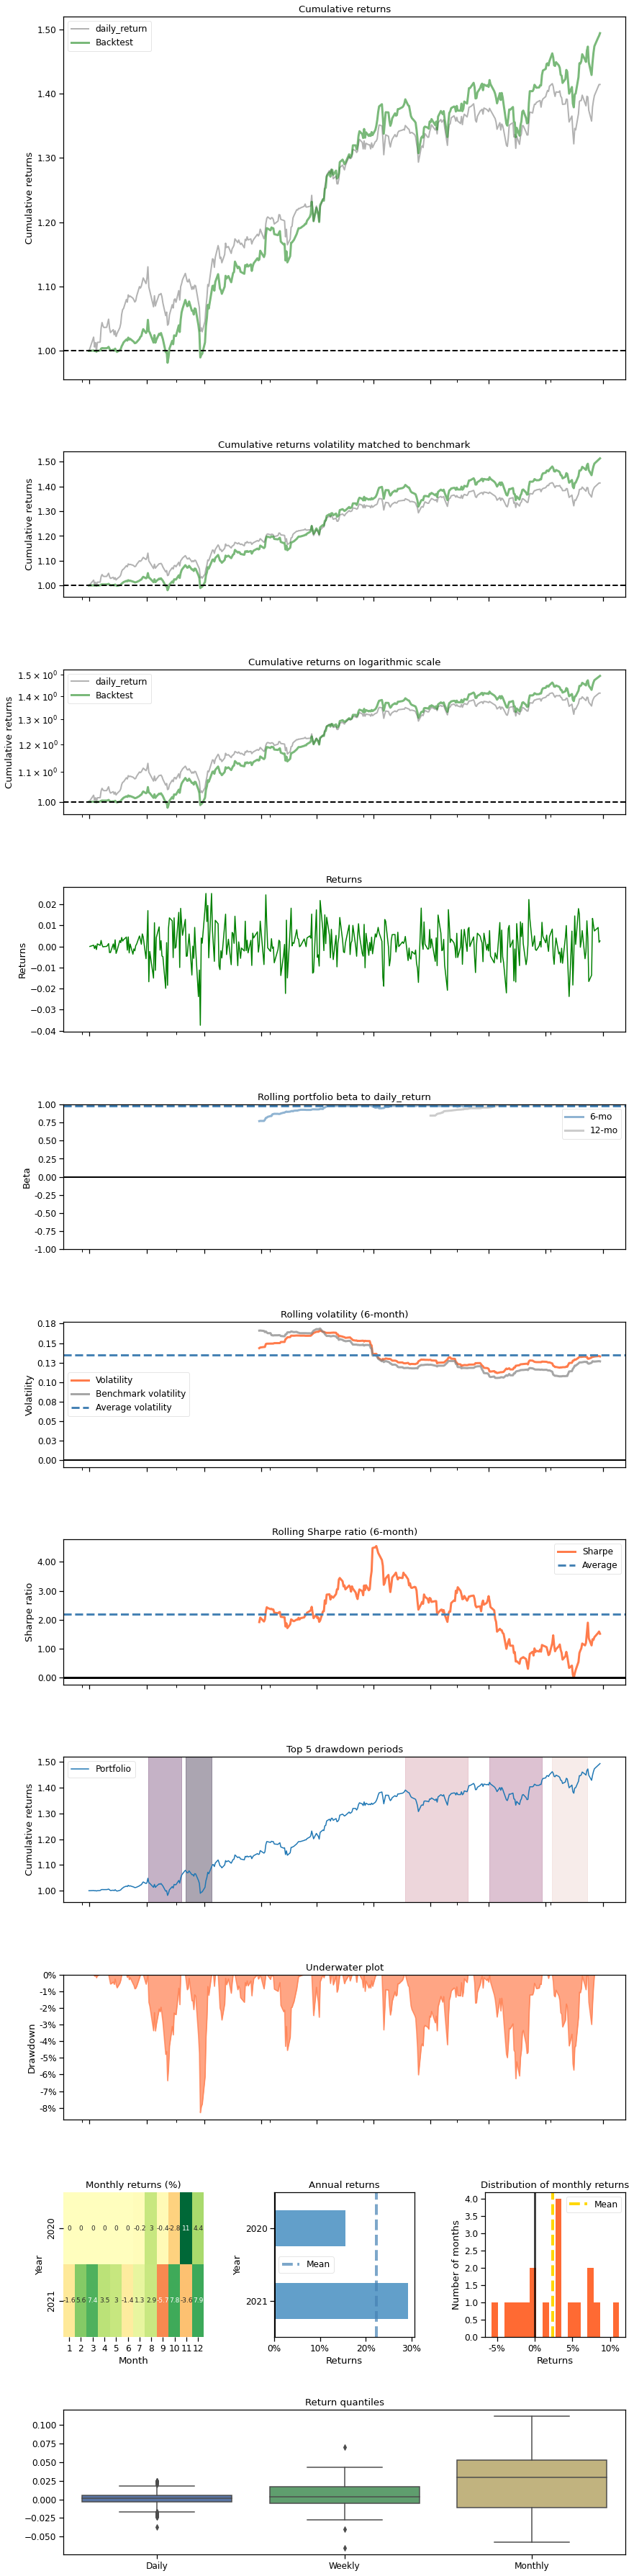

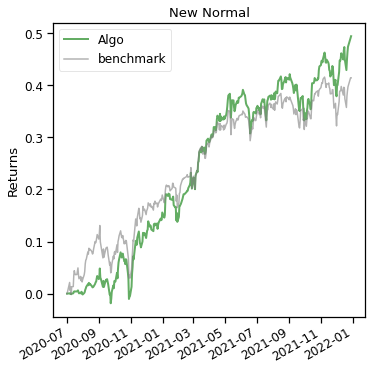

In [134]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value_td3, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value_td3.loc[0,'date'],
             baseline_end = df_account_value_td3.loc[len(df_account_value_td3)-1,'date'])